In [77]:
import os
import neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
import neptune

In [64]:
# NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='

# project = neptune.init_project(
#     project='revivemed/RCC',
#     mode="read-only",
#     api_token=NEPTUNE_API_TOKEN
# )

# vae_runs_table_df = project.fetch_runs_table(query='`pretrain/original_kwargs/encoder_kind`="VAE"',limit=1000).to_pandas()

# # project.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/


TypeError: fetch_runs_table() got an unexpected keyword argument 'query'

## Read in the dataframes

In [79]:
file1 = '/Users/jonaheaton/Desktop/All April12 1pm part1.csv'
file2 = '/Users/jonaheaton/Desktop/All April12 1pm part2.csv'

file1 = '/Users/jonaheaton/Desktop/All April15 part1.csv'
file2 = '/Users/jonaheaton/Desktop/All April15 part2.csv'


file1 = '/Users/jonaheaton/Desktop/All April17 part1.csv'
file2 = '/Users/jonaheaton/Desktop/All April17 part2.csv'
file3 = '/Users/jonaheaton/Desktop/All April17 part3.csv'

df2 = pd.read_csv(file2, index_col=0)
df1 = pd.read_csv(file1, index_col=0)
df3 = pd.read_csv(file3, index_col=0)
df = df1.join(df2, how='outer', lsuffix='_1', rsuffix='_2')
df = df.join(df3, how='outer', rsuffix='_3')

In [83]:
# get the important tages
from collections import defaultdict
important_tags = ['april17_best90','april17_pareto','april15_leila']
runs_with_tags_dict= defaultdict(list)

for tag in important_tags:
    for run_id in df.index:
        tags_in_run = eval(df.loc[run_id]['Tags_1'])
        if tag in tags_in_run:
            runs_with_tags_dict[tag].append(run_id)

## Cleanup and Simplify the dataframe to the essential bits

In [84]:
pretrain_objectives = ['Reconstruction Loss (val)',' StudyID AUC (val)', 'CohortLabel AUC (val)','Gender AUC (val)','AgeGroup AUC (val)', 'Age MAE (val)']


finetune_objectives = ['MSKCC AUC (finetune, val)', 'MSKCC AUC (finetune, train)', 'MSKCC AUC (randinit, val)',\
                       'IMDC AUC (finetune, val)', 'IMDC AUC (finetune, train)', 'IMDC AUC (randinit, val)']

key_params = ['Latent dim', '# hidden layers','']#, 'Learning Rate', 'Num Epochs']


search_dct = {
    'Reconstruction Loss (val)': {
        'must_contain_all': ['recon','val'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'StudyID AUC (val)': {
        'must_contain_all': ['StudyID','AUROC','val'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'CohortLabel AUC (val)': {
        'must_contain_all': ['AUROC','val'],
        'must_contain_one': ['CohortLabel','Cohort Label'],
        'exact_matches': []
    },
    'Gender AUC (val)': {
        'must_contain_all': ['AUROC','val'],
        'must_contain_one': ['isFemale','Gender'],
        'exact_matches': []
    },
    'AgeGroup AUC (val)': {
        'must_contain_all': ['AUROC','val','isPediatric'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'Age MAE (val)': {
        'must_contain_all': ['MAE','val'],
        'must_contain_one': ['Age'],
        'exact_matches': []
    },
    'MSKCC AUC (finetune, val)': {
        'must_contain_all': ['MSKCC','finetune','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'MSKCC AUC (finetune, train)': {
        'must_contain_all': ['MSKCC','finetune','train'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['variance','std'],
        'exact_matches': []
    },
    'MSKCC AUC (randinit, val)': {
        'must_contain_all': ['MSKCC','randinit','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'IMDC AUC (finetune, val)': {
        'must_contain_all': ['IMDC','finetune','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'IMDC AUC (finetune, train)': {
        'must_contain_all': ['IMDC','finetune','train'],
        'must_contain_one': ['AUROC','AUC'],
        'exact_matches': [],
        'must_not_contain': ['variance','std'],
    },
    'IMDC AUC (randinit, val)': {
        'must_contain_all': ['IMDC','randinit','val'],
        'must_contain_one': ['AUROC','AUC'],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'Latent dim': {
        'must_contain_all': ['latent'],
        'must_contain_one': [],
        'exact_matches': []
    },
    '# hidden layers': {
        'must_contain_all': ['layers'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'encoder kind':{
        'must_contain_all': ['encoder','kind'],
        'must_contain_one': [],
        'exact_matches': []
    },
    'Both OS C-Index (finetune, val)': {
        'must_contain_all': ['both-OS','finetune','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'Both OS C-Index (finetune, train)': {
        'must_contain_all': ['both-OS','finetune','train','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std'],
        'exact_matches': []
    },
    'Both OS C-Index (randinit, val)': {
        'must_contain_all': ['both-OS','randinit','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'Both PFS C-Index (finetune, val)': {
        'must_contain_all': ['both-PFS','finetune','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
    'Both PFS C-Index (finetune, train)': {
        'must_contain_all': ['both-PFS','finetune','train','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['variance','std'],
        'exact_matches': []
    },
    'Both PFS C-Index (randinit, val)': {
        'must_contain_all': ['both-PFS','randinit','val','Concordance'],
        'must_contain_one': [],
        'must_not_contain': ['train','variance','std'],
        'exact_matches': []
    },
}




In [85]:
# find the matches to the search dictionary for each important objective/parameter

input_cols = df.columns
selected_cols = []

for obj in search_dct.keys():

    print(obj)
    for col in df.columns:
        
        # first check of the column is already selected for an objective
        if col in selected_cols:
            continue

        # then check for exact matches
        if col in search_dct[obj]['exact_matches']:
            # print(obj, col)
            selected_cols.append(col)

        # then check if the column contains all of the must_contain_all words
        elif len(search_dct[obj]['must_contain_all'])==0 or all([x.lower() in col.lower() for x in search_dct[obj]['must_contain_all']]):
            if len(search_dct[obj]['must_contain_one'])==0 or any([x.lower() in col.lower() for x in search_dct[obj]['must_contain_one']]):
                if len(search_dct[obj].get('must_not_contain', []))==0 or all([x.lower() not in col.lower() for x in search_dct[obj].get('must_not_contain', [])]):

                    # print(obj, col)
                    selected_cols.append(col)
            
                    search_dct[obj]['exact_matches'].append(col)
            

Reconstruction Loss (val)
StudyID AUC (val)
CohortLabel AUC (val)
Gender AUC (val)
AgeGroup AUC (val)
Age MAE (val)
MSKCC AUC (finetune, val)
MSKCC AUC (finetune, train)
MSKCC AUC (randinit, val)
IMDC AUC (finetune, val)
IMDC AUC (finetune, train)
IMDC AUC (randinit, val)
Latent dim
# hidden layers
encoder kind
Both OS C-Index (finetune, val)
Both OS C-Index (finetune, train)
Both OS C-Index (randinit, val)
Both PFS C-Index (finetune, val)
Both PFS C-Index (finetune, train)
Both PFS C-Index (randinit, val)


In [86]:
# use the search_dct to create a new dataframe from the selected columns

df = df[selected_cols].copy()

for obj in search_dct.keys():
    if len(search_dct[obj]['exact_matches'])==0:
        print(obj, 'not found')
        continue

    if len(search_dct[obj]['exact_matches'])==1:
        # rename the column to the objective name
        df = df.rename(columns={search_dct[obj]['exact_matches'][0]: obj})
    
    else:
        print(obj, 'multiple matches', search_dct[obj]['exact_matches'])
        # merge the columns into a single column
        # if the columns are numeric then take the mean
        if all(df[search_dct[obj]['exact_matches']].dtypes != 'object'):
            df[obj] = df[search_dct[obj]['exact_matches']].mean(axis=1) # ignore nan
            
        else:
            # if the columns are not numeric then take the first one
            df[obj] = df[search_dct[obj]['exact_matches'][0]]
        df = df.drop(columns=search_dct[obj]['exact_matches'])
        


Reconstruction Loss (val) multiple matches ['pretrain/eval/val/reconstruction_loss (last)', 'val recon loss']
StudyID AUC (val) multiple matches ['pretrain/eval/val/MultiClass_Adv StudyID__AUROC (ovo, macro) (last)', 'val StudyID AUROC']
CohortLabel AUC (val) multiple matches ['pretrain/eval/val/MultiClass_Cohort Label__AUROC (ovo, macro) (last)', 'val Cohort Label AUROC']
Gender AUC (val) multiple matches ['pretrain/eval/val/Binary_isFemale__AUROC (micro) (last)', 'val isFemale AUROC']
AgeGroup AUC (val) multiple matches ['pretrain/eval/val/Binary_isPediatric__AUROC (micro) (last)', 'val isPediatric AUROC']
Age MAE (val) multiple matches ['pretrain/eval/val/Regression_Age__MAE (last)', 'val Age MAE']
MSKCC AUC (finetune, val) multiple matches ['MSKCC_finetune/eval/val/Binary_MSKCC__AUROC (micro) (average)', 'MSKCC AUC finetune Val (v1)']
MSKCC AUC (finetune, train) multiple matches ['MSKCC_finetune/eval/train/Binary_MSKCC__AUROC (micro) (average)', 'MSKCC AUC finetune Train (v1)']
MSK

In [87]:
df

,Latent dim,# hidden layers,"Both OS C-Index (finetune, val)","Both OS C-Index (randinit, val)","Both PFS C-Index (finetune, val)","Both PFS C-Index (randinit, val)",Reconstruction Loss (val),StudyID AUC (val),CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),Age MAE (val),"MSKCC AUC (finetune, val)","MSKCC AUC (finetune, train)","MSKCC AUC (randinit, val)","IMDC AUC (finetune, val)","IMDC AUC (finetune, train)","IMDC AUC (randinit, val)",encoder kind
Id,,,,,,,,,,,,,,,,,,,
RCC-1000,8.0,2.0,NaN,NaN,NaN,NaN,0.615857,0.762010,NaN,NaN,0.995434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1001,8.0,2.0,NaN,NaN,NaN,NaN,0.646021,0.879790,0.992842,NaN,0.996190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1002,8.0,2.0,NaN,NaN,NaN,NaN,0.595628,0.601806,NaN,NaN,0.619367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1003,8.0,2.0,NaN,NaN,NaN,NaN,0.599536,0.616415,0.573812,NaN,0.635276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-1004,8.0,2.0,NaN,NaN,NaN,NaN,0.622126,0.796842,NaN,NaN,0.974340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-995,8.0,1.0,NaN,NaN,NaN,NaN,0.605717,0.871321,0.988293,NaN,0.995399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-996,8.0,2.0,NaN,NaN,NaN,NaN,0.722247,0.604794,NaN,NaN,0.587050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE
RCC-997,8.0,2.0,NaN,NaN,NaN,NaN,0.623891,0.796035,0.850271,NaN,0.978337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AE


In [88]:
df['model complexity'] = df['Latent dim']*df['# hidden layers']
df['MSKCC AUC Diff (finetune-randinit)'] = df['MSKCC AUC (finetune, val)'] - df['MSKCC AUC (randinit, val)']
df['IMDC AUC Diff (finetune-randinit)'] = df['IMDC AUC (finetune, val)'] - df['IMDC AUC (randinit, val)']
df['Both OS C-Index Diff (finetune-randinit)'] = df['Both OS C-Index (finetune, val)'] - df['Both OS C-Index (randinit, val)']
df['Both PFS C-Index Diff (finetune-randinit)'] = df['Both PFS C-Index (finetune, val)'] - df['Both PFS C-Index (randinit, val)']

In [89]:
# add the import tags
for tag in important_tags:
    df['Has Tag '+tag] = df.index.isin(runs_with_tags_dict[tag])

In [90]:
df.dropna(subset=['Gender AUC (val)','Age MAE (val)'], inplace=True)

# drop outliers in the Age MAE
df = df[df['Age MAE (val)']<100].copy()


## Now that it is clean we can do analysis

In [91]:
pretrain_objectives = ['Reconstruction Loss (val)','StudyID AUC (val)', 'CohortLabel AUC (val)','Gender AUC (val)','AgeGroup AUC (val)', 'Age MAE (val)']


finetune_objectives = ['MSKCC AUC (finetune, val)', 'MSKCC AUC (randinit, val)',\
                       'IMDC AUC (finetune, val)', 'IMDC AUC (randinit, val)',\
                        'Both OS C-Index (finetune, val)', 'Both OS C-Index (randinit, val)',
                        'Both PFS C-Index (finetune, val)', 'Both PFS C-Index (randinit, val)']

key_params = ['Latent dim', '# hidden layers','model complexity']#, 'Learning Rate', 'Num Epochs']

key_cols = pretrain_objectives+finetune_objectives+key_params

In [92]:
df['encoder kind'].value_counts()

encoder kind
VAE             642
AE              310
TGEM_Encoder      1
Name: count, dtype: int64

In [93]:
ae_models = df[df['encoder kind']=='AE'].copy()
vae_models = df[df['encoder kind']=='VAE'].copy()


In [94]:
ae_models.sort_values('Age MAE (val)',ascending=True, inplace=True)
ae_models.sort_values('Gender AUC (val)', inplace=True, ascending=False)
ae_models.to_csv('/Users/jonaheaton/Desktop/ae_models.csv')


vae_models.sort_values('Age MAE (val)',ascending=True, inplace=True)
vae_models.sort_values('Gender AUC (val)', inplace=True, ascending=False)
vae_models.to_csv('/Users/jonaheaton/Desktop/vae_models.csv')

In [95]:
def update_directions_and_scales(df):

    df['neg log Reconstruction Loss (val)'] = -1* np.log(df['Reconstruction Loss (val)'])
    # remove the old column
    df = df.drop(columns=['Reconstruction Loss (val)'])

    df['neg Age MAE'] = -1*df['Age MAE (val)']
    df['neg Age MSE'] = -1*df['Age MAE (val)']
    df['neg StudyID AUC (val)'] = -1*df['StudyID AUC (val)']
    df.drop(columns=['Age MAE (val)','Age MAE (val)','StudyID AUC (val)'], inplace=True)


    df.drop(columns=['MSKCC AUC (finetune, train)', 'IMDC AUC (finetune, train)','neg Age MSE'], inplace=True)
    # drop the columns about tags
    df.drop(columns=[col for col in df.columns if 'Has Tag' in col], inplace=True)
    # drop any non-numeric columns
    df = df.select_dtypes(include=[np.number]).copy()

    

    return df

In [18]:
# ae_model_clean = update_directions_and_scales(ae_models.copy())


In [22]:
# Compute the correlation matrix

# corr_matrix = ae_model_clean.corr(method='spearman')

# # Plot the correlation matrix
# # make the plot bigger
# plt.figure(figsize=(20, 16))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Spearman Correlation Matrix (AE Model)')

# # rotate the x-axis labels
# plt.xticks(rotation=45, ha='right')

# plt.savefig('/Users/jonaheaton/Desktop/ae_correlation_matrix.png')

In [23]:
# sns.set_context('notebook')
# nonan_corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
# nonan_corr_matrix = nonan_corr_matrix.dropna(axis=0).dropna(axis=1).round(2)

# plt.figure(figsize=(26, 24))
# cax = sns.clustermap(nonan_corr_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 7})
# plt.xticks(rotation=45, ha='right')

# # Set colorbar label size
# cax.cax.yaxis.set_tick_params(labelsize=8)

# # Set colorbar label size
# cax.cax.yaxis.set_tick_params(labelsize=8)

# # Set axis label size
# cax.ax_heatmap.tick_params(axis='both', which='both', labelsize=8)

# # add a title to the clustergird
# cax.ax_col_dendrogram.set_title('Spearman Correlation Matrix (AE Model)')

# plt.savefig('/Users/jonaheaton/Desktop/ae_clustered_correlation_matrix.png')

In [24]:
vae_model_clean = update_directions_and_scales(vae_models.copy())

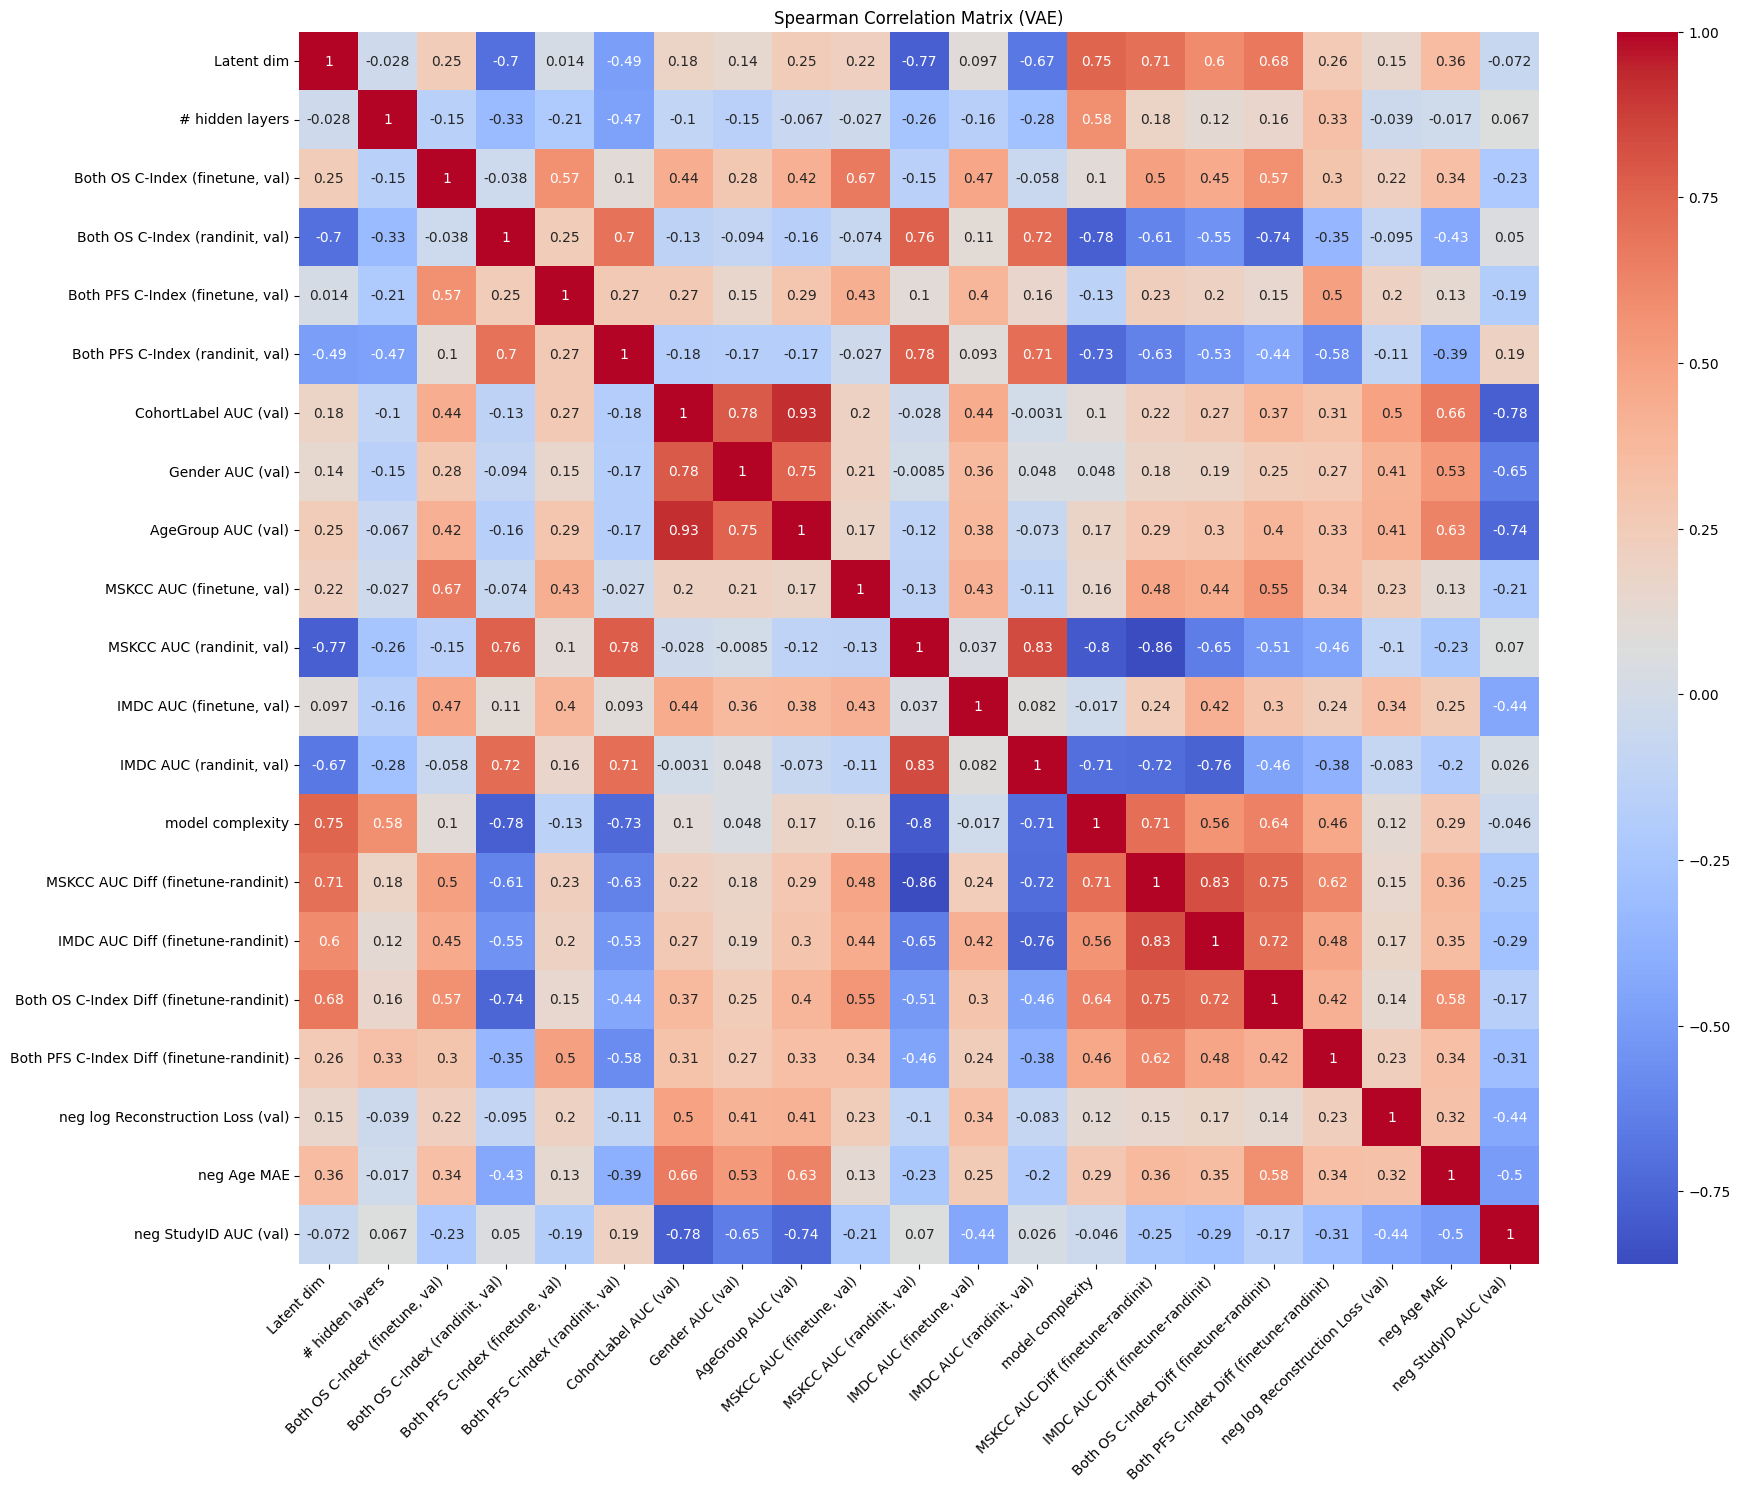

In [96]:
# Compute the correlation matrix

corr_matrix = vae_model_clean.corr(method='spearman')

# Plot the correlation matrix
# make the plot bigger
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix (VAE)')

# rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.savefig('/Users/jonaheaton/Desktop/vae_correlation_matrix.png')

<Figure size 2600x2400 with 0 Axes>

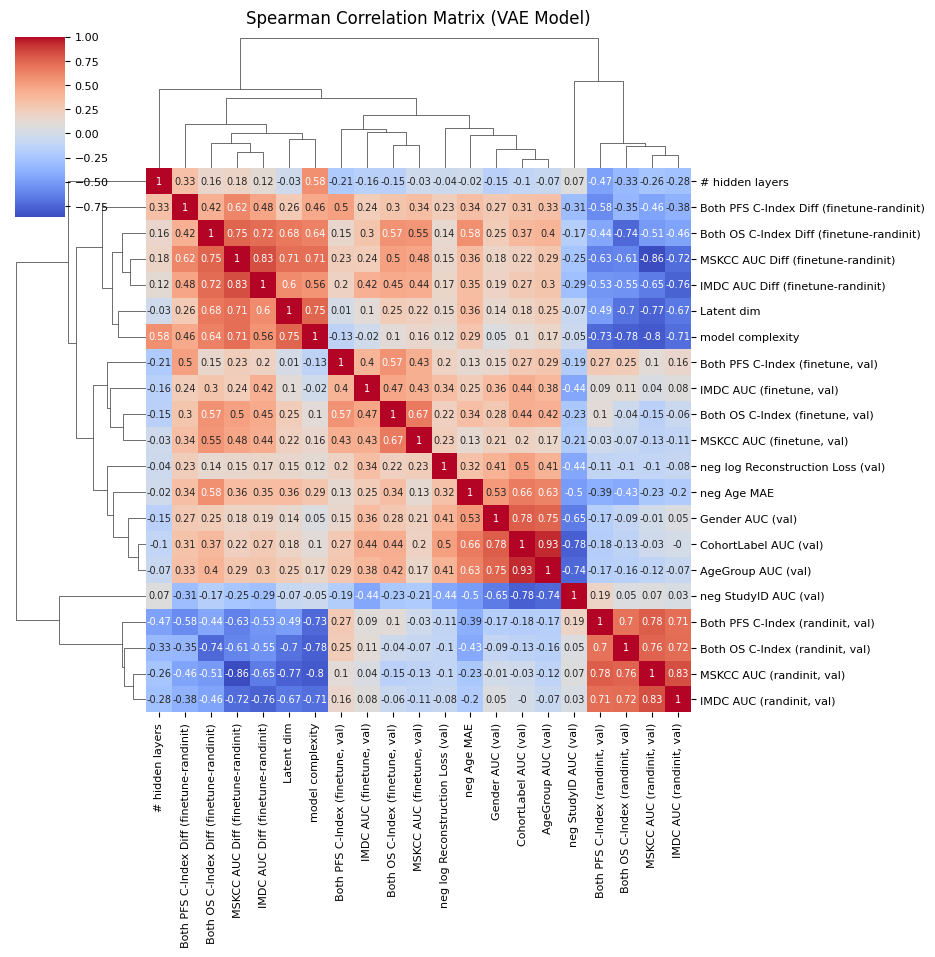

In [97]:
# sns.set_context('notebook')
nonan_corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
nonan_corr_matrix = nonan_corr_matrix.dropna(axis=0).dropna(axis=1).round(2)

plt.figure(figsize=(26, 24))
cax = sns.clustermap(nonan_corr_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 7})
plt.xticks(rotation=45, ha='right')

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set colorbar label size
cax.cax.yaxis.set_tick_params(labelsize=8)

# Set axis label size
cax.ax_heatmap.tick_params(axis='both', which='both', labelsize=8)

# add a title to the clustergird
cax.ax_col_dendrogram.set_title('Spearman Correlation Matrix (VAE Model)')

plt.savefig('/Users/jonaheaton/Desktop/vae_clustered_correlation_matrix.png')

## Choose the best runs using the pareto front

In [36]:
from paretoset import paretoset

In [37]:
def pareto_reduction(df, sense_list=None, current_set=None, desired_num=None, objective_cols=None):
    
    if desired_num is None:
        desired_num = np.floor(0.2*df.shape[0])
    if objective_cols is None:
        objective_cols = df.columns
    if sense_list is None:
        sense_list = ['max' for _ in objective_cols]

    if df.shape[0] < desired_num*1.5:
        return df

    mask = paretoset(df[objective_cols], sense=sense_list)
    current_set = pd.concat([current_set, df[mask]])
    if current_set.shape[0] < desired_num:
        return pareto_reduction(df[~mask], sense_list, current_set, desired_num, objective_cols)
    else:
        return current_set
    

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1

    df_out = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    
    return df_out    

In [99]:
vae_model_clean.shape

(641, 21)

In [98]:
(~vae_model_clean['MSKCC AUC (finetune, val)'].isna()).sum()


525

In [38]:
vae_model_clean

,Latent dim,# hidden layers,"Both OS C-Index (finetune, val)","Both OS C-Index (randinit, val)","Both PFS C-Index (finetune, val)","Both PFS C-Index (randinit, val)",CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),"MSKCC AUC (finetune, val)",...,"IMDC AUC (finetune, val)","IMDC AUC (randinit, val)",model complexity,MSKCC AUC Diff (finetune-randinit),IMDC AUC Diff (finetune-randinit),Both OS C-Index Diff (finetune-randinit),Both PFS C-Index Diff (finetune-randinit),neg log Reconstruction Loss (val),neg Age MAE,neg StudyID AUC (val)
Id,,,,,,,,,,,,,,,,,,,,,
RCC-3013,80.0,5.0,0.687362,0.520318,0.545353,0.5,0.990883,0.890305,0.998471,NaN,...,NaN,NaN,400.0,NaN,NaN,0.167044,0.045353,0.053260,-9.093743,-0.541620
RCC-2559,56.0,3.0,NaN,NaN,NaN,NaN,0.827350,0.889301,0.965923,0.872840,...,0.888733,0.775097,168.0,0.346869,0.113636,NaN,NaN,0.300080,-10.521715,-0.777997
RCC-2987,119.0,4.0,NaN,NaN,0.553891,0.5,0.989760,0.887873,0.995976,NaN,...,NaN,NaN,476.0,NaN,NaN,NaN,0.053891,0.676420,-9.704203,-0.504746
RCC-2507,29.0,2.0,NaN,NaN,NaN,NaN,0.979680,0.886695,0.995847,0.829365,...,0.879332,0.806061,58.0,0.131834,0.073271,NaN,NaN,0.450439,-8.908306,-0.881439
RCC-2549,61.0,2.0,NaN,NaN,NaN,NaN,0.823431,0.886217,0.970000,0.869621,...,0.894872,0.729060,122.0,0.365873,0.165812,NaN,NaN,0.053255,-10.877678,-0.766172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2731,63.0,5.0,NaN,NaN,NaN,NaN,0.446569,0.471697,0.502566,0.510009,...,0.500000,0.691064,315.0,0.009083,-0.191064,NaN,NaN,0.570014,-39.654396,-0.588918
RCC-2828,42.0,5.0,0.500000,0.634237,0.500000,0.5,0.530451,0.468668,0.382603,0.510031,...,0.500000,0.827972,210.0,-0.073942,-0.327972,-0.134237,0.000000,0.550870,-38.956985,-0.604487
RCC-2657,45.0,3.0,NaN,NaN,NaN,NaN,0.700982,0.465275,0.794672,0.829233,...,0.913287,0.829371,135.0,0.260847,0.083916,NaN,NaN,0.062284,-9.603444,-0.702336


In [104]:
# pretrain_clean_objectives = ['Gender AUC (val)','AgeGroup AUC (val)','CohortLabel AUC (val)','neg Age MAE','neg StudyID AUC (val)','neg log Reconstruction Loss (val)']

pretrain_clean_objectives = ['Gender AUC (val)','AgeGroup AUC (val)','CohortLabel AUC (val)','neg Age MAE','neg log Reconstruction Loss (val)']
df_obj = vae_model_clean[pretrain_clean_objectives].copy()

In [105]:
df_obj = remove_outliers(df_obj,'neg Age MAE')
df_obj = remove_outliers(df_obj,'neg log Reconstruction Loss (val)')

In [57]:
df_obj.shape

(578, 5)

In [101]:
vae_model_subset = vae_model_clean.copy()
vae_model_subset = vae_model_subset.loc[df_obj.index].copy()

print('Finetune Statistics')
mkscc_finetune_count = (~vae_model_subset['MSKCC AUC (finetune, val)'].isna()).sum()
imdc_finetune_count = (~vae_model_subset['IMDC AUC (finetune, val)'].isna()).sum()
both_os_finetune_count = (~vae_model_subset['Both OS C-Index (finetune, val)'].isna()).sum()
both_pfs_finetune_count = (~vae_model_subset['Both PFS C-Index (finetune, val)'].isna()).sum()

print('MSKCC Finetune Count', mkscc_finetune_count)
print('IMDC Finetune Count', imdc_finetune_count)
print('Both OS Finetune Count', both_os_finetune_count)
print('Both PFS Finetune Count', both_pfs_finetune_count)

Finetune Statistics
MSKCC Finetune Count 462
IMDC Finetune Count 462
Both OS Finetune Count 105
Both PFS Finetune Count 110


In [108]:
pareto_df2 = pareto_reduction(df_obj.round(1))

In [109]:
pareto_df2.shape

(121, 5)

In [58]:
pareto_df = pareto_reduction(df_obj.round(5))

In [59]:
pareto_df.shape

(157, 5)

In [60]:
pareto_df

,Gender AUC (val),AgeGroup AUC (val),CohortLabel AUC (val),neg Age MAE,neg log Reconstruction Loss (val)
Id,,,,,
RCC-3013,0.89030,0.99847,0.99088,-9.09374,0.05326
RCC-2559,0.88930,0.96592,0.82735,-10.52172,0.30008
RCC-2987,0.88787,0.99598,0.98976,-9.70420,0.67642
RCC-2507,0.88669,0.99585,0.97968,-8.90831,0.45044
RCC-2658,0.88389,0.99531,0.89848,-8.52497,0.55652
...,...,...,...,...,...
RCC-2534,0.59572,0.99677,0.93390,-9.65191,0.44834
RCC-2188,0.59532,0.99104,0.98242,-10.10154,0.67078
RCC-2633,0.57152,0.99536,0.90196,-9.19095,0.58346


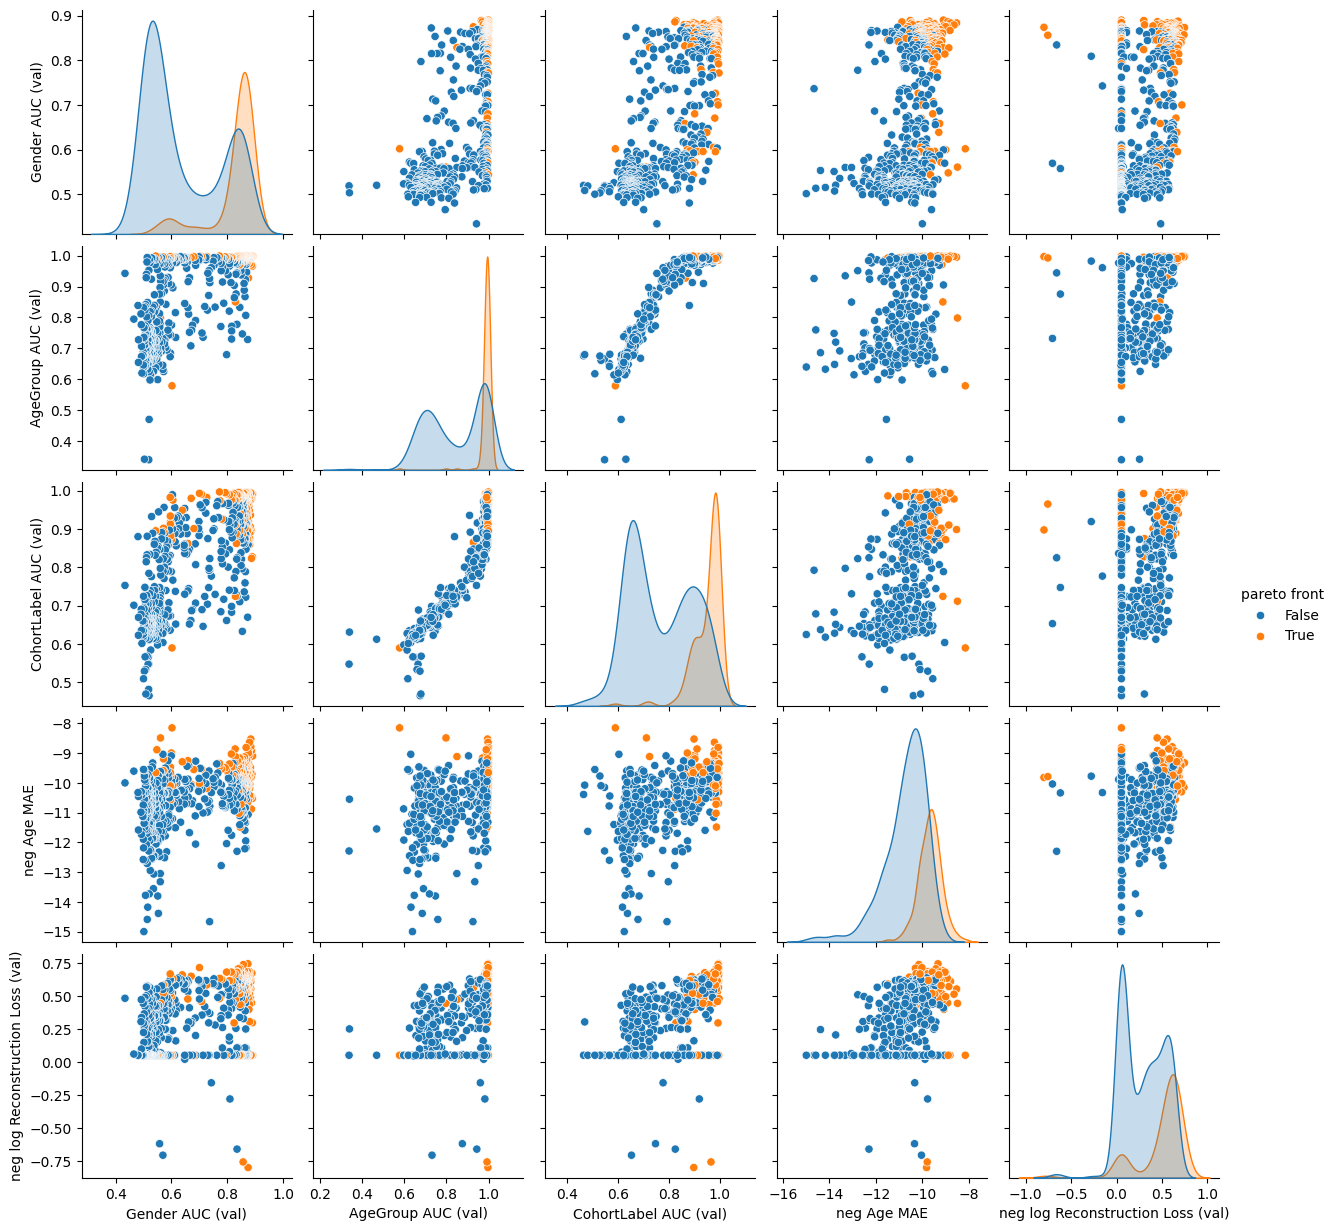

In [61]:
df_obj['pareto front'] = False
df_obj.loc[pareto_df.index, 'pareto front'] = True
sns.pairplot(df_obj, hue='pareto front')

In [90]:
NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [62]:
## Add tag to the top models


chosen_runs = pareto_df.index.tolist()

for run_id in chosen_runs:
    run = neptune.init_run(project='revivemed/RCC', api_token=NEPTUNE_API_TOKEN, with_id=run_id)
    run['sys/tags'].add('april17_pareto')
    run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-3013
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-3013/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2559
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2559/m

In [34]:
vae_model_clean

,Latent dim,# hidden layers,CohortLabel AUC (val),Gender AUC (val),AgeGroup AUC (val),"MSKCC AUC (finetune, val)","MSKCC AUC (randinit, val)","IMDC AUC (finetune, val)","IMDC AUC (randinit, val)",model complexity,MSKCC AUC Diff (finetune-randinit),IMDC AUC Diff (finetune-randinit),neg log Reconstruction Loss (val),neg Age MAE,neg StudyID AUC (val)
Id,,,,,,,,,,,,,,,
RCC-2559,56.0,3.0,0.827350,0.889301,0.965923,0.871098,0.501720,0.887762,0.798601,168.0,0.369378,0.089161,0.300080,-10.521715,-0.777997
RCC-2507,29.0,2.0,0.979680,0.886695,0.995847,0.829960,0.722884,0.881002,0.842657,58.0,0.107077,0.038345,0.450439,-8.908306,-0.881439
RCC-2549,61.0,2.0,0.823431,0.886217,0.970000,0.869775,0.500000,0.895338,0.767949,122.0,0.369775,0.127389,0.053255,-10.877678,-0.766172
RCC-2676,42.0,1.0,0.978687,0.884760,0.997477,0.862500,0.870106,0.889860,0.893939,42.0,-0.007606,-0.004079,0.053262,-10.449822,-0.877224
RCC-2691,38.0,2.0,0.980738,0.884177,0.996623,0.858399,0.654630,0.896037,0.845396,76.0,0.203770,0.050641,-2.432603,-9.323588,-0.889493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RCC-2805,42.0,5.0,0.512258,0.472676,0.422462,NaN,NaN,NaN,NaN,210.0,NaN,NaN,0.561059,-39.789707,-0.603648
RCC-2731,63.0,5.0,0.446569,0.471697,0.502566,0.522288,0.501786,0.500000,0.728322,315.0,0.020503,-0.228322,0.570014,-39.654396,-0.588918
RCC-2657,45.0,3.0,0.700982,0.465275,0.794672,0.828968,0.563690,0.912587,0.804895,135.0,0.265278,0.107692,0.062284,-9.603444,-0.702336


## Tag best models from list

In [27]:
NEPTUNE_API_TOKEN = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGM5ZDhiMy1kOTlhLTRlMTAtOGFlYy1hOTQzMDE1YjZlNjcifQ=='


In [33]:
best_list_file = '/Users/jonaheaton/Desktop/april17 best.csv'
chosen_runs = pd.read_csv(best_list_file)['id'].tolist()

In [35]:
for run_id in chosen_runs:
    run = neptune.init_run(project='revivemed/RCC', api_token=NEPTUNE_API_TOKEN, with_id=run_id)
    run['sys/tags'].add('april17_best90')
    run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2704
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2704/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/revivemed/RCC/e/RCC-2964
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/revivemed/RCC/e/RCC-2964/m